In [1]:
# Import Packages
import pandas as pd
import numpy as np
from scipy.stats import zscore
import re
from textblob import TextBlob
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load the dataset
file_path = 'vaccination_all_tweets.csv'
tweets_df = pd.read_csv(file_path)

In [3]:
# Display the columns of the dataset
tweets_df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [4]:
# Display the first few rows of the dataset
tweets_df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [36]:
# Descriptive statistics for numerical columns
tweets_df.describe()

,id,user_followers,user_friends,user_favourites,date,retweets,favorites,sentiment
count,2.282070e+05,2.282070e+05,228207.000000,2.282070e+05,228207,228207.000000,228207.000000,228207.000000
mean,1.407541e+18,9.605393e+04,986.736204,1.210417e+04,2021-06-23 03:29:23.522911232,2.489284,10.819020,0.088277
min,1.337728e+18,0.000000e+00,0.000000,0.000000e+00,2020-12-12 11:55:28,0.000000,0.000000,-1.000000
25%,1.381940e+18,5.500000e+01,27.000000,5.700000e+01,2021-04-13 11:58:42,0.000000,0.000000,0.000000
50%,1.408133e+18,3.280000e+02,229.000000,9.960000e+02,2021-06-24 18:39:17,0.000000,0.000000,0.000000
75%,1.428688e+18,1.521000e+03,794.000000,7.300000e+03,2021-08-20 11:58:32,1.000000,2.000000,0.187689
max,1.463251e+18,1.635305e+07,582461.000000,1.299600e+06,2021-11-23 20:58:08,12294.000000,54017.000000,1.000000
std,2.908485e+16,8.389053e+05,5293.500468,3.908233e+04,NaN,51.079821,199.527693,0.225750


In [5]:
# Basic tokenization using regex
def basic_tokenize(text):
    # Convert to lowercase and split by non-word characters (removes punctuation)
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

# Apply tokenization
tweets_df['tokens'] = tweets_df['text'].apply(basic_tokenize)

# Display the first few rows with tokenized text
print(tweets_df[['date', 'text', 'tokens']].head())

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

                                              tokens  
0  [same, folks, said, daikon, paste, could, trea...  
1  [while, the, world, has, been, on, the, wrong,...  
2  [coronavirus, sputnikv, astrazeneca, pfizerbio...  
3  [facts, are, immutable, senator, even, when, y...  
4  [explain, to, me, again, why, we, need, a, vac...  


In [6]:
# Apply sentiment analysis using TextBlob
tweets_df['sentiment'] = tweets_df['text'].apply(lambda text: TextBlob(text).sentiment.polarity)

# Display the first few rows with the sentiment column
print(tweets_df[['date', 'text', 'sentiment']].head())

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   
2  2020-12-12 20:33:45  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  2020-12-12 20:23:59  Facts are immutable, Senator, even when you're...   
4  2020-12-12 20:17:19  Explain to me again why we need a vaccine @Bor...   

   sentiment  
0       0.00  
1      -0.50  
2       0.00  
3      -0.05  
4       0.00  


In [7]:
# Aggregate Sentiment Scores by Time

# Ensure the 'date' column is in datetime format
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

# Group by date and calculate the average sentiment
daily_sentiment = tweets_df.groupby(tweets_df['date'].dt.date)['sentiment'].mean()

# Convert the daily sentiment series into a DataFrame for further analysis
daily_sentiment_df = daily_sentiment.reset_index()

# Display the aggregated daily sentiment scores
print(daily_sentiment_df.head())

         date  sentiment
0  2020-12-12   0.067223
1  2020-12-13   0.105537
2  2020-12-14   0.113316
3  2020-12-15   0.117846
4  2020-12-16   0.110607


In [8]:
############################
### Time Series Analysis ###
############################

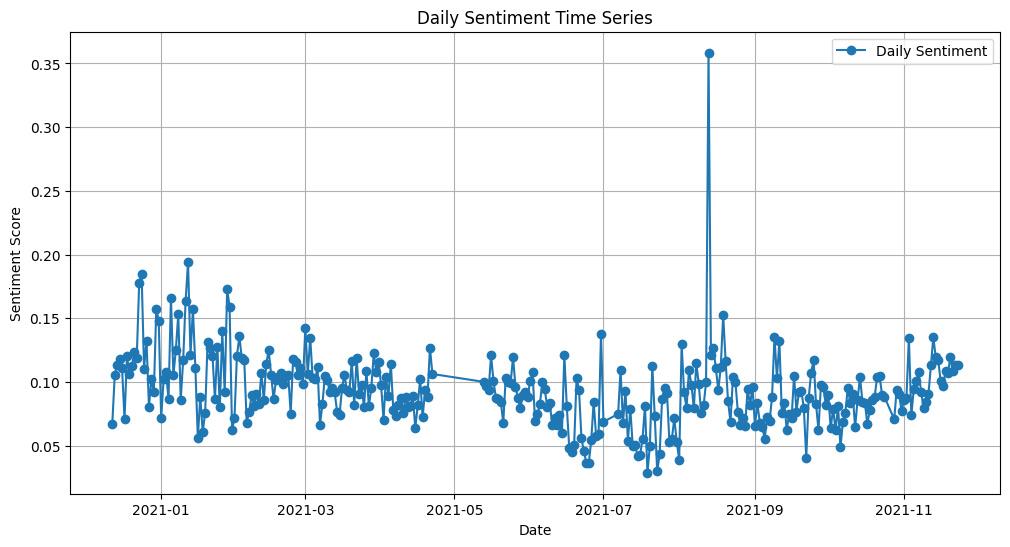

In [9]:
# Plot the daily sentiment time series
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment_df['date'], daily_sentiment_df['sentiment'], label='Daily Sentiment', marker = 'o')
plt.title('Daily Sentiment Time Series')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Identify Date of Spike

# Find the index of the row with the maximum average sentiment
spike_index = daily_sentiment_df['sentiment'].idxmax()

# Get the actual date of the spike
spike_date = daily_sentiment_df.loc[spike_index, 'date']

# Print the spike date and the corresponding sentiment value
print(f'Spike Date: {spike_date}')
print(f"Maximum Sentiment Value: {daily_sentiment_df.loc[spike_index, 'sentiment']}")

Spike Date: 2021-08-13
Maximum Sentiment Value: 0.3584266373827356


In [11]:
# Examine Tweets on Spike Date

# Filter the tweets from the spike date
spike_tweets = tweets_df[tweets_df['date'].dt.date == spike_date]

# Display the tweets from that day
print(spike_tweets[['date', 'text', 'sentiment']])

                      date                                               text  \
157750 2021-08-13 06:01:44  3rd dose. Booster 1. #PfizerBiontech https://t...   
157927 2021-08-13 06:23:51  #COVID19 #vaccinated #VACCINE #Truth #Pfizer #...   
157928 2021-08-13 03:26:48  #moderna and #pfizer are outstanding vaccines ...   
157929 2021-08-13 01:11:29  Thanks #Moderna #vaccinated #COVID19 #Truth ht...   
158320 2021-08-13 05:47:32  This Chart captures India's #Vaccination Drive...   
...                    ...                                                ...   
166981 2021-08-13 08:16:58  [COVID Support]\nWockhardt Inks Pact To Produc...   
166982 2021-08-13 08:14:32  Wockhardt partners with the Russian Direct Inv...   
166983 2021-08-13 08:10:04  Delta cases surge in US &amp; Israel shows mRN...   
166984 2021-08-13 08:00:35  45+ #BBMP #Bengaluru #CovidVaccine Availabilit...   
166985 2021-08-13 08:00:24  45+ #URBAN #Bengaluru #CovidVaccine Availabili...   

        sentiment  
157750 

In [12]:
# Check for Outliers
daily_sentiment_df['z_score'] = zscore(daily_sentiment_df['sentiment'])
print(daily_sentiment_df[daily_sentiment_df['z_score'].abs() > 3])  # Days with z-score > 3 might be outliers

           date  sentiment   z_score
12   2020-12-24   0.184444  3.002475
31   2021-01-12   0.194071  3.321268
219  2021-08-13   0.358427  8.763617


In [13]:
# Replace the outlier on 2021-08-13 with the average of surrounding values

# Calculate the average of surrounding values (3 days before and 3 days after)
surrounding_values = daily_sentiment_df['sentiment'].iloc[spike_index-3:spike_index].tolist() + daily_sentiment_df['sentiment'].iloc[spike_index+1:spike_index+4].tolist()
average_surrounding_value = sum(surrounding_values) / len(surrounding_values)

# Replace the outlier with the average of surrounding values
daily_sentiment_df.at[spike_index, 'sentiment'] = average_surrounding_value

# Print the new value at the spike index
print(f"New Sentiment Value at Spike Date: {daily_sentiment_df.loc[spike_index, 'sentiment']}")

New Sentiment Value at Spike Date: 0.10266455557398825


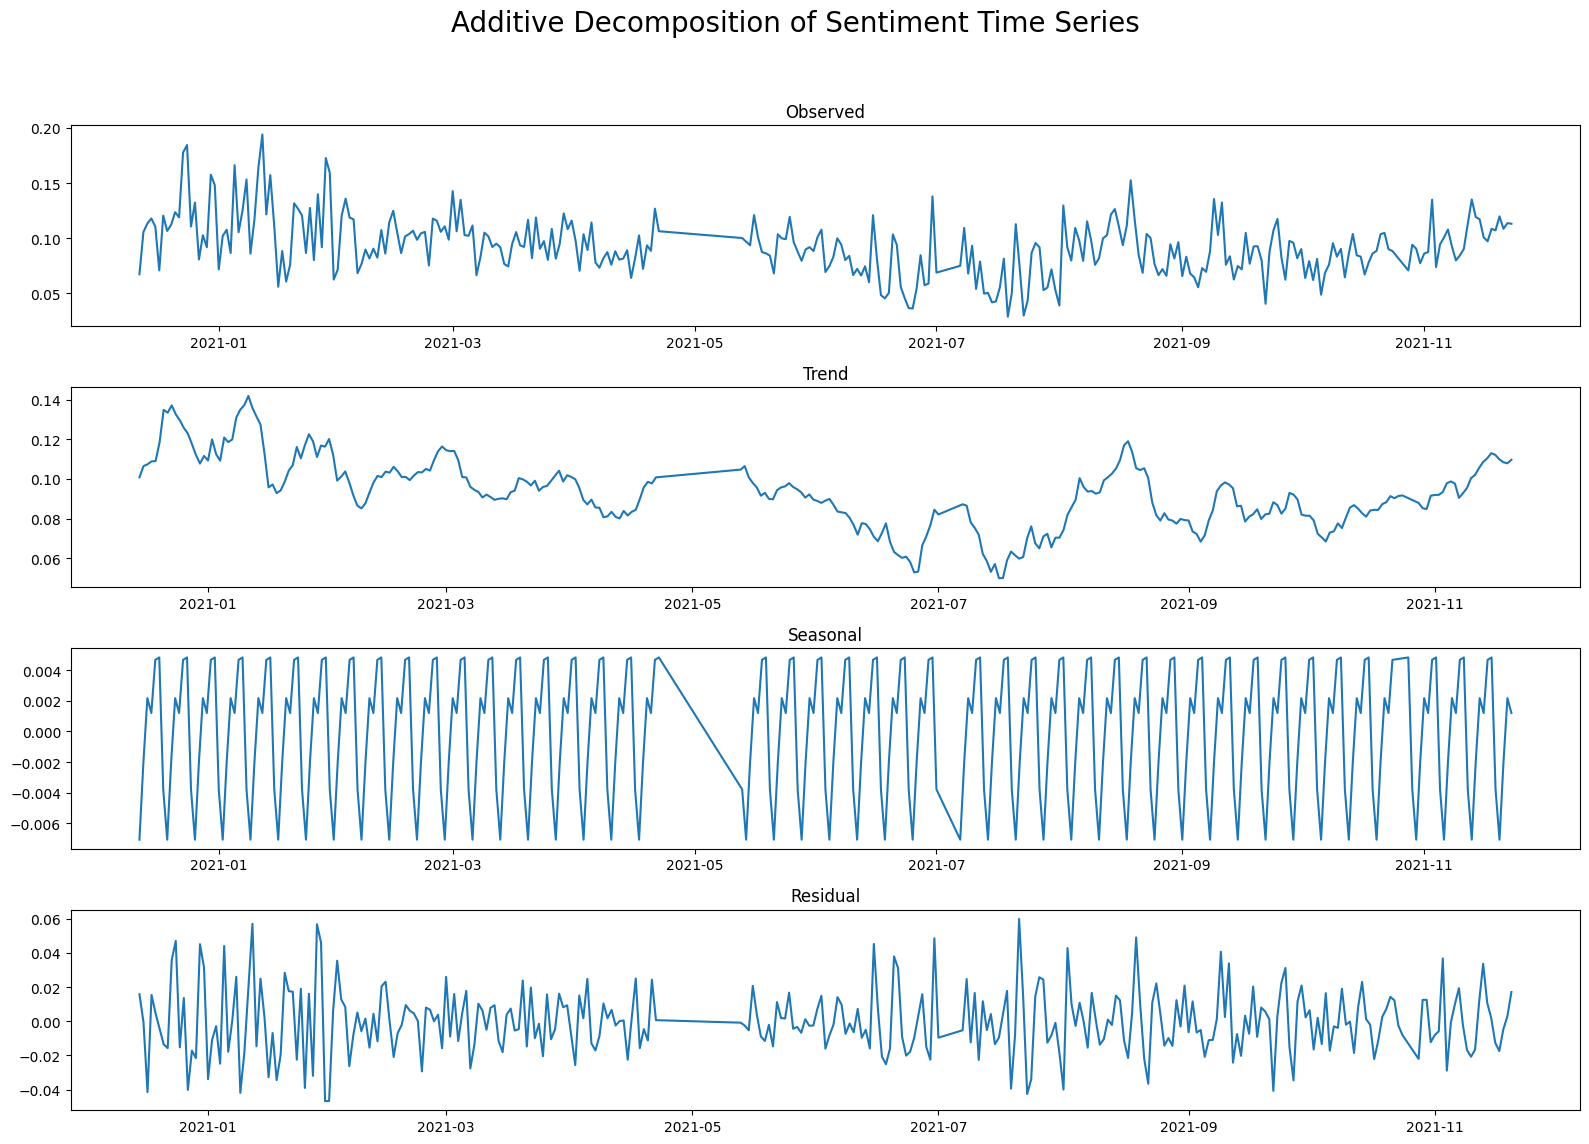

In [14]:
# Additive Decomposition

# Ensure the index is in datetime format for decomposition
daily_sentiment_df['date'] = pd.to_datetime(daily_sentiment_df['date'])
daily_sentiment_df.set_index('date', inplace=True)

# Perform additive decomposition
decomposition = seasonal_decompose(daily_sentiment_df['sentiment'], model='additive', period=7)

# Create a new figure with the desired size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 12))

# Plot each component separately
ax1.plot(decomposition.observed)
ax1.set_title('Observed')

ax2.plot(decomposition.trend)
ax2.set_title('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_title('Residual')

# Set the overall title for the figure
fig.suptitle('Additive Decomposition of Sentiment Time Series', fontsize=20)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

In [15]:
# ADF Test for Stationarity

# Perform ADF test
adf_test = adfuller(daily_sentiment_df['sentiment'])

# Extract and print the test results
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print(f'Critical Value {key}: {value}')

print('Therefore, the time series is stationary')

ADF Statistic: -3.478001843154693
p-value: 0.00857035652011932
Critical Value 1%: -3.4514843502727306
Critical Value 5%: -2.8708485956333556
Critical Value 10%: -2.571729625657462
Therefore, the time series is stationary


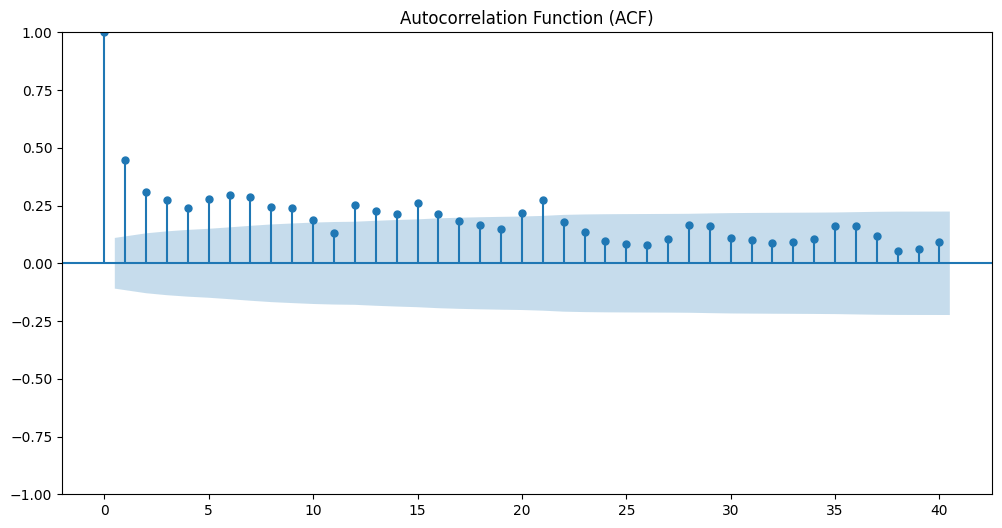

In [16]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(daily_sentiment_df['sentiment'].dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

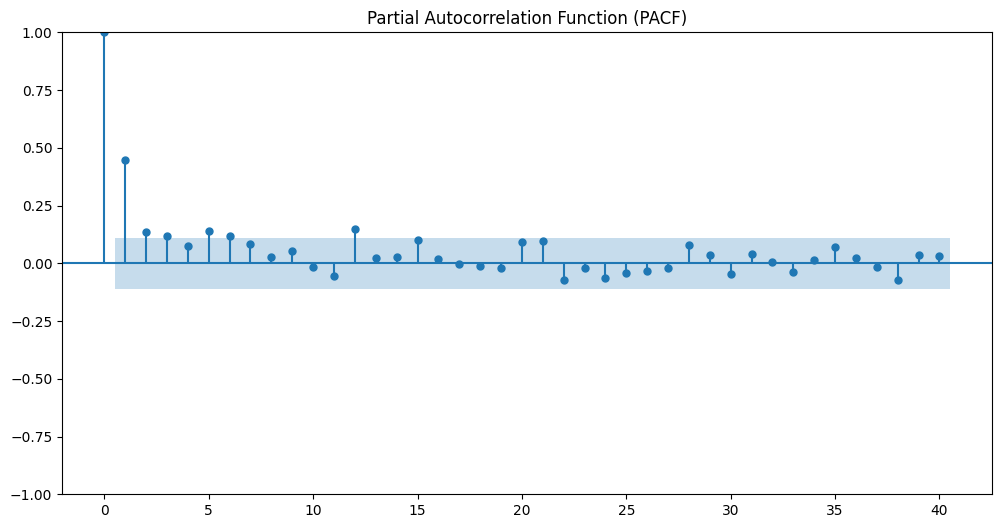

In [17]:
# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(daily_sentiment_df['sentiment'].dropna(), lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [18]:
# Fit the ARIMA Model

# Fit auto_arima to find the best model
model = auto_arima(daily_sentiment_df['sentiment'], seasonal=False, trace=True)

# Fit the model
model.fit(daily_sentiment_df['sentiment'])

# Display the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1492.757, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1374.565, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1420.736, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1486.122, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1376.556, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1492.776, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1496.351, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1493.742, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1496.828, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1494.817, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1442.802, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1498.802, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1488.121, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1422.724, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0

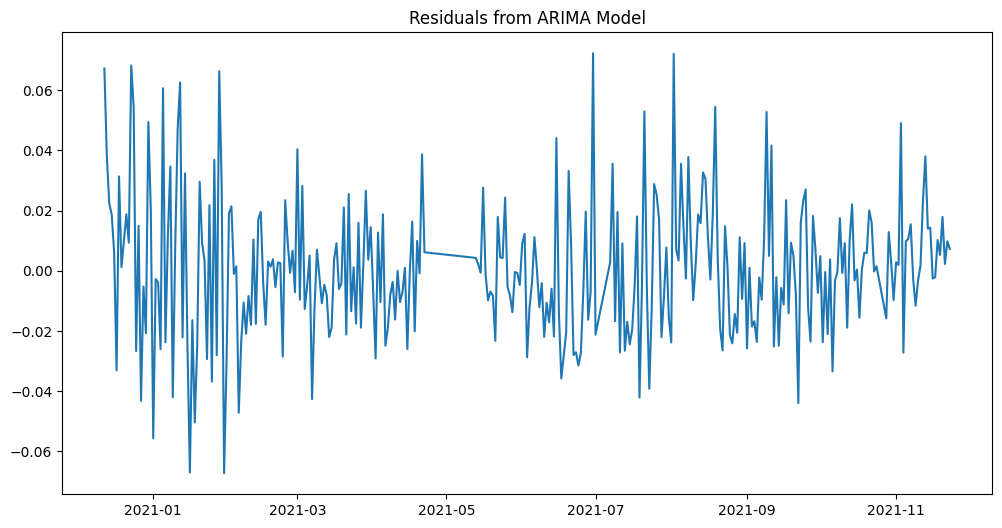

In [19]:
# Residual Plot

# Get the residuals from the model
residuals = model.resid()

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

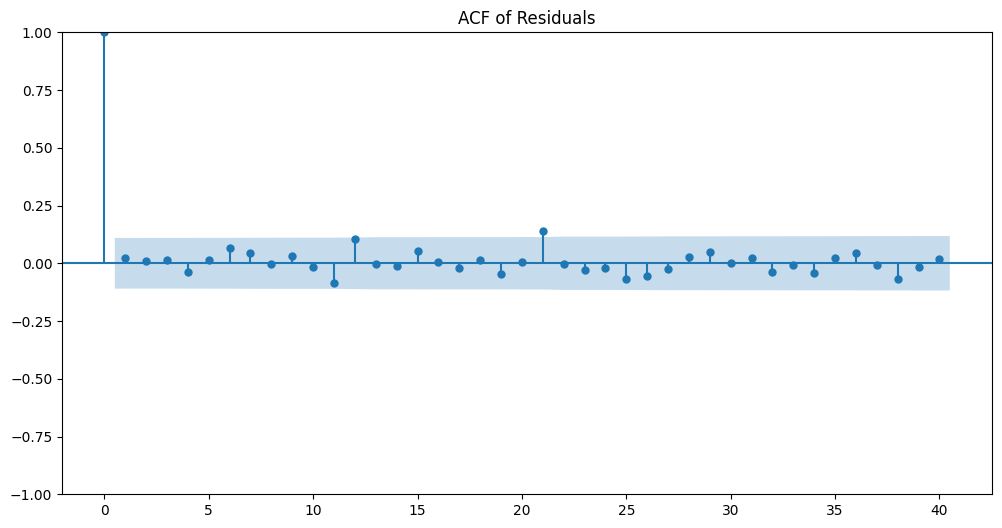

In [20]:
# ACF of Residuals Plot

plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')
plt.show()

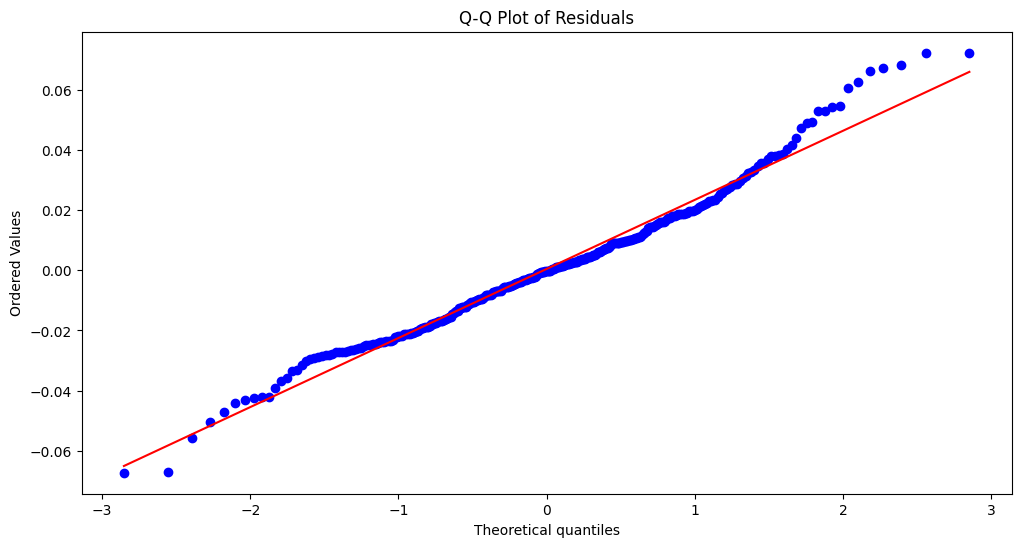

In [21]:
# Q-Q Plot of Residuals

plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist='norm', plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [22]:
# Ljung-Box Test

# Perform the Ljung-Box test across multiple lags
# Test for lags 1 to 20
ljung_box_result = acorr_ljungbox(residuals, lags=list(range(1, 21)), return_df=True)

# Print the Ljung-Box test results
print('Ljung-Box Test Results for each lag:')
print(ljung_box_result)

Ljung-Box Test Results for each lag:
      lb_stat  lb_pvalue
1    0.168488   0.681459
2    0.204059   0.903003
3    0.262395   0.966938
4    0.774635   0.941816
5    0.832670   0.974903
6    2.227537   0.897628
7    2.920987   0.892214
8    2.922416   0.939132
9    3.233324   0.954322
10   3.302943   0.973370
11   5.843779   0.883582
12   9.498361   0.659877
13   9.502702   0.734006
14   9.568008   0.793036
15  10.575283   0.782080
16  10.593685   0.833844
17  10.722297   0.870631
18  10.787542   0.903154
19  11.565597   0.903345
20  11.573171   0.929984


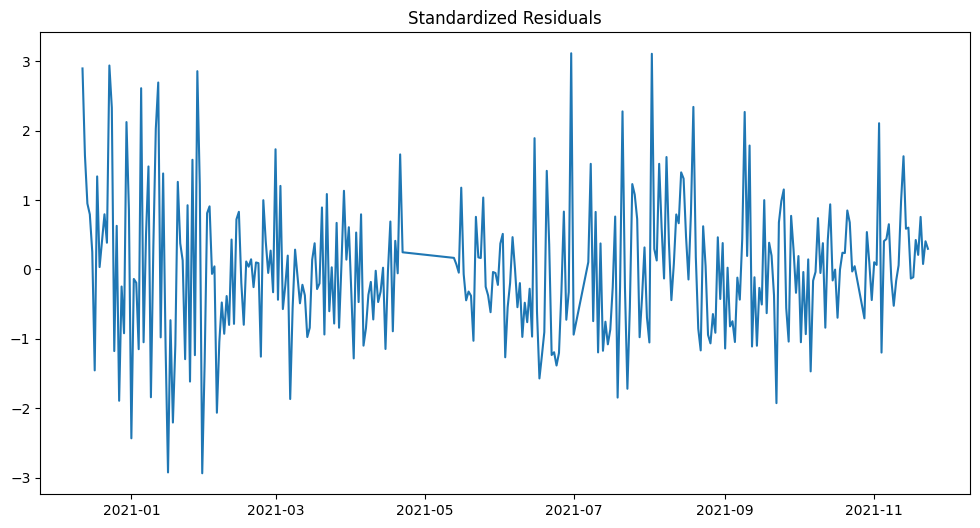

In [23]:
# Standardized residuals

standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Plot the standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(standardized_residuals)
plt.title('Standardized Residuals')
plt.show()

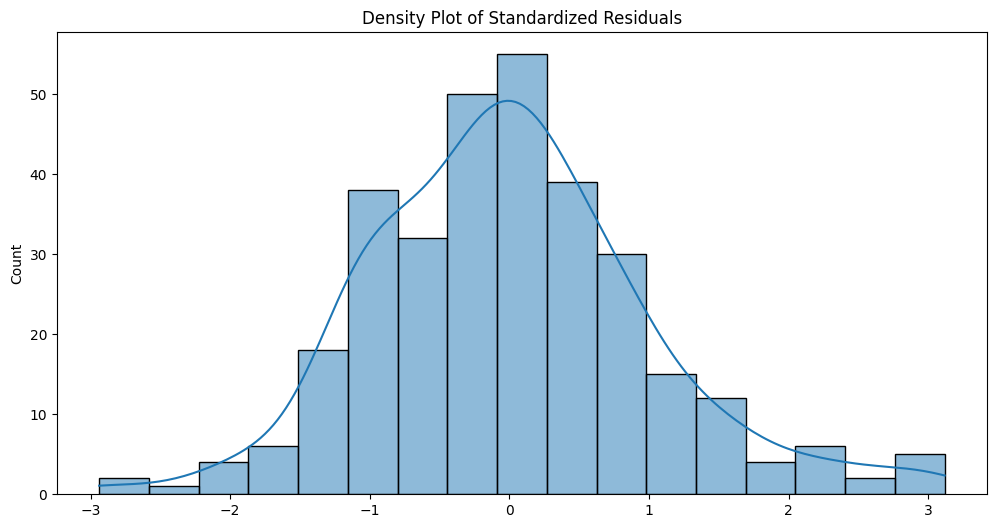

In [24]:
# Plot the distribution of standardized residuals
plt.figure(figsize=(12, 6))
sns.histplot(standardized_residuals, kde=True)
plt.title('Density Plot of Standardized Residuals')
plt.show()

In [25]:
# Splitting the Dataset (80% Training, 20% Testing)

# Ensure the index is in datetime format and set the frequency
daily_sentiment_df.index = pd.to_datetime(daily_sentiment_df.index)

# Set the frequency of the time series to daily
daily_sentiment_df = daily_sentiment_df.asfreq('D')

In [26]:
# Check missing values
daily_sentiment_df['sentiment'].isna().sum()

28

In [27]:
# Interpolate missing values

# Interpolate the NaN values using a spline of order 2
daily_sentiment_df['sentiment'] = daily_sentiment_df['sentiment'].interpolate(method='spline', order=2)

# Check the result to ensure NaN values have been interpolated
print(daily_sentiment_df['sentiment'].isna().sum())

0


In [28]:
# Split data into training and testing

# Determine the split point
split_point = int(len(daily_sentiment_df) * 0.8)

# Split the data into training and testing datasets
train_data = daily_sentiment_df['sentiment'][:split_point]
test_data = daily_sentiment_df['sentiment'][split_point:]

# Print the number of observations in each dataset
print(f'Training data length: {len(train_data)}')
print(f'Testing data length: {len(test_data)}')

Training data length: 277
Testing data length: 70


In [29]:
# Fitting the ARIMA(1,1,1) Model on the Training Data

model = ARIMA(train_data, order=(1, 1, 1))
fitted_model = model.fit()

# Display the model summary
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:              sentiment   No. Observations:                  277
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 648.478
Date:                Thu, 22 Aug 2024   AIC                          -1290.957
Time:                        16:10:15   BIC                          -1280.096
Sample:                    12-12-2020   HQIC                         -1286.598
                         - 09-14-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2501      0.061      4.112      0.000       0.131       0.369
ma.L1         -0.9344      0.025    -37.492      0.000      -0.983      -0.886
sigma2         0.0005   3.93e-05     13.484      0.0

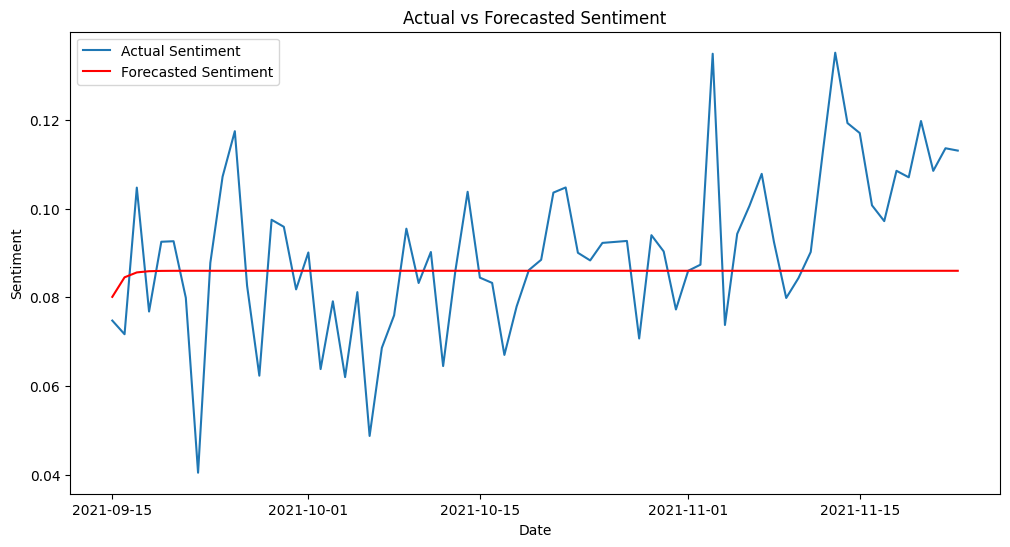

In [30]:
# Forecasting on the Testing Data

forecast = fitted_model.forecast(steps=len(test_data))

# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Sentiment')
plt.plot(test_data.index, forecast, label='Forecasted Sentiment', color='red')
plt.title('Actual vs Forecasted Sentiment')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.show()

In [31]:
# Evaluate the Model

# Align the test data and forecast data by their indices
aligned_test_data, aligned_forecast = test_data.align(forecast, join='inner')

# Calculate MSE and MAE
mse = mean_squared_error(aligned_test_data, aligned_forecast)
mae = mean_absolute_error(aligned_test_data, aligned_forecast)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((aligned_test_data - aligned_forecast) / aligned_test_data)) * 100

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 0.00033776869966603085
Mean Absolute Error (MAE): 0.0140020570305032
Mean Absolute Percentage Error (MAPE): 16.25%


In [32]:
# Holt-Winters Model

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(train_data, trend='additive', seasonal=None, initialization_method='estimated').fit()

# Forecast the test data period
hw_forecast = hw_model.forecast(steps=len(test_data))

# Ensure the forecast has the correct date index
hw_forecast.index = test_data.index

In [33]:
# Evaluate the Holt-Winters Model on the Test Data

# Align the test data and Holt-Winters forecast
aligned_test_data_hw, aligned_forecast_hw = test_data.align(hw_forecast, join='inner')

# Handle any NaN values (if they exist)
aligned_test_data_hw = aligned_test_data_hw.dropna()
aligned_forecast_hw = aligned_forecast_hw.loc[aligned_test_data_hw.index]

# Calculate MSE, MAE, MAPE for Holt-Winters forecast
mse_hw = mean_squared_error(aligned_test_data_hw, aligned_forecast_hw)
mae_hw = mean_absolute_error(aligned_test_data_hw, aligned_forecast_hw)
mape_hw = np.mean(np.abs((aligned_test_data_hw - aligned_forecast_hw) / aligned_test_data_hw)) * 100

# Print the evaluation metrics for Holt-Winters model
print(f'Holt-Winters Mean Squared Error (MSE): {mse_hw}')
print(f'Holt-Winters Mean Absolute Error (MAE): {mae_hw}')
print(f'Holt-Winters Mean Absolute Percentage Error (MAPE): {mape_hw:.2f}%')

Holt-Winters Mean Squared Error (MSE): 0.0004036064107622237
Holt-Winters Mean Absolute Error (MAE): 0.015547325250667151
Holt-Winters Mean Absolute Percentage Error (MAPE): 17.55%


In [34]:
# Compare the Two Forecasting Models

# Create a DataFrame for the comparison
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'MAPE'],
    'ARIMA': [mse, mae, f'{mape:.2f}%'],
    'Holt-Winters': [mse_hw, mae_hw, f'{mape_hw:.2f}%']
})

# Display the DataFrame as a table
print(comparison_df)
print(f'\nThe ARIMA forecast slightly outperforms the Holt-Winters forecast across all three metrics')

  Metric     ARIMA Holt-Winters
0    MSE  0.000338     0.000404
1    MAE  0.014002     0.015547
2   MAPE    16.25%       17.55%

The ARIMA forecast slightly outperforms the Holt-Winters forecast across all three metrics


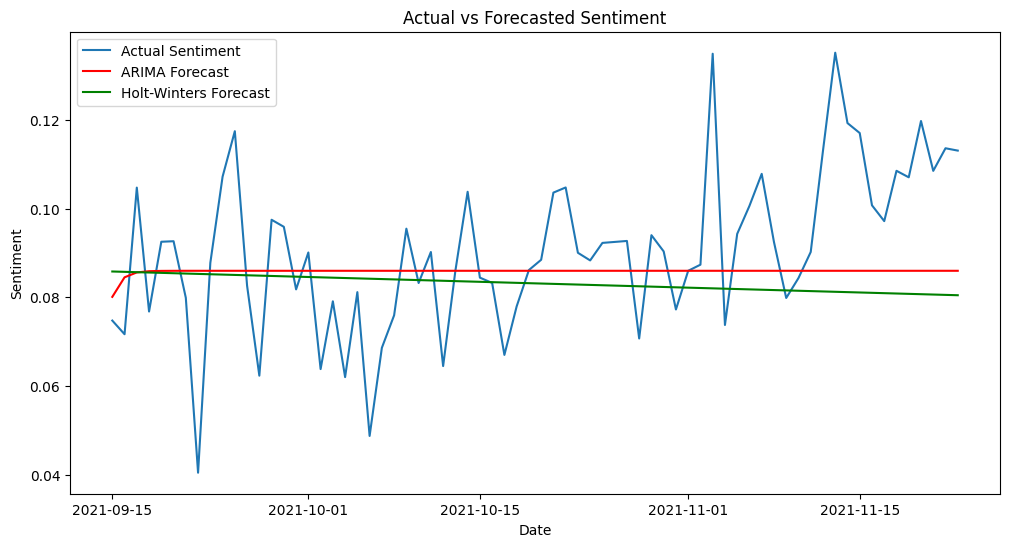

In [35]:
# Plot the Results

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Sentiment')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.plot(test_data.index, hw_forecast, label='Holt-Winters Forecast', color='green')
plt.title('Actual vs Forecasted Sentiment')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.show()